In [36]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [22]:
accidents_weather = pd.read_csv("../nesrece_vreme_LJ_2010_2023.csv")

In [23]:
ljubljana_weather = pd.read_csv("../ljubljana_vreme_2010_2023.csv")

In [24]:
lj_accidents = pd.read_csv("../ljubljana_nesrece_2010_2023.csv")
#print(lj_accidents['NastanekDatumCas'].dtype)

### Priprava podatkov

In [25]:
lj_accidents['NastanekDatumCas'] = pd.to_datetime(lj_accidents['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')

lj_accidents['NastanekDatumCas'] = pd.to_datetime(lj_accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')
if lj_accidents['NastanekDatumCas'].dt.tz is None:
    # Če podatki nimajo določenega time zone-a, potem jih lokaliziramo na Ljubljano
    lj_accidents['NastanekDatumCas'] = lj_accidents['NastanekDatumCas'].dt.tz_localize('Europe/Ljubljana')
else:
    # Če imajo timezone, ampak je napačen, ga pretvorimo v Ljubljano
    lj_accidents['NastanekDatumCas'] = lj_accidents['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')

print(f"NastanekDatumCas column dtype: {lj_accidents['NastanekDatumCas'].dtype}")


# Dodaj stolpec, ki bo vseboval minute
lj_accidents['Minute'] = lj_accidents['NastanekDatumCas'].dt.minute

# Zaokroži čase v lj_accidents na polno uro navzdol
lj_accidents['DatumCasZaokrozen'] = lj_accidents['NastanekDatumCas'].dt.floor(freq='h', ambiguous=True)

# Času prištej eno uro
lj_accidents['DatumCasZaokrozen_PlusEna'] = lj_accidents['DatumCasZaokrozen'] + pd.Timedelta(hours=1)


ljubljana_weather['date'] = pd.to_datetime(ljubljana_weather['date'], format='ISO8601', errors='coerce')
if ljubljana_weather['date'].dt.tz is None:
    # Če podatki nimajo določenega time zone-a, potem jih lokaliziramo na Ljubljano
    ljubljana_weather['date'] = ljubljana_weather['date'].dt.tz_localize('Europe/Ljubljana')
else:
    # Če imajo timezone, ampak je napačen, ga pretvorimo v Ljubljano
    ljubljana_weather['date'] = ljubljana_weather['date'].dt.tz_convert('Europe/Ljubljana')
print(f"Weather date column dtype: {ljubljana_weather['date'].dtype}")

# print(lj_accidents['NastanekDatumCas'].iloc[0])
# print(ljubljana_weather['date'].iloc[0])
# print(lj_accidents['DatumCasZaokrozen'].dtype)
# print(lj_accidents['DatumCasZaokrozen_PlusEna'].dtype)

# Naredimo prvi merge, da dobimo količno dežja za uro nesreče
lj_accidents = lj_accidents.merge(
    ljubljana_weather[['date', 'rain']],
    how='left',
    left_on='DatumCasZaokrozen', right_on='date'
)

# Naredimo drugi merge, da dobimo količno dežja za uro po nesreči
lj_accidents = lj_accidents.merge(
    ljubljana_weather[['date', 'rain']].rename(columns={'date': 'date2', 'rain': 'rain_plusEna'}),
    how='left',
    left_on='DatumCasZaokrozen_PlusEna', right_on='date2'
)

ni_nic = (lj_accidents['rain'] != 0.0)
print(f"Number of accidents with rain: {ni_nic.sum()}")
print(f"Missing rain data: {lj_accidents['rain'].isnull().sum()}")
#display(lj_accidents[ni_nic])

#display(lj_accidents)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]
Weather date column dtype: datetime64[ns, Europe/Ljubljana]
Number of accidents with rain: 469
Missing rain data: 0


#### Dodajanje stolpcev

In [75]:
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
lj_accidents['NastanekDatumCas'] = pd.to_datetime(lj_accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')

day_translation = {
    'Monday': 'Ponedeljek',
    'Tuesday': 'Torek',
    'Wednesday': 'Sreda',
    'Thursday': 'Četrtek',
    'Friday': 'Petek',
    'Saturday': 'Sobota',
    'Sunday': 'Nedelja'
}
day_order_slo = ['Ponedeljek', 'Torek', 'Sreda', 'Četrtek', 'Petek', 'Sobota', 'Nedelja']

month_translation = {
    'January': 'Januar', 'February': 'Februar', 'March': 'Marec',
    'April': 'April', 'May': 'Maj', 'June': 'Junij',
    'July': 'Julij', 'August': 'Avgust', 'September': 'September',
    'October': 'Oktober', 'November': 'November', 'December': 'December'
}
month_order_slo = ['Januar', 'Februar', 'Marec', 'April', 'Maj', 'Junij', 'Julij', 'Avgust', 'September', 'Oktober', 'November', 'December']

lj_accidents['Day_EN'] = lj_accidents['NastanekDatumCas'].dt.day_name()
lj_accidents['Day_SLO'] = lj_accidents['Day_EN'].map(day_translation)

lj_accidents['Mesec_EN'] = lj_accidents['NastanekDatumCas'].dt.month_name()
lj_accidents['Mesec_SLO'] = lj_accidents['Mesec_EN'].map(month_translation)

lj_accidents['Datum'] = lj_accidents['NastanekDatumCas'].dt.date
lj_accidents['Ura'] = lj_accidents['NastanekDatumCas'].dt.hour

lj_accidents['Teden'] = lj_accidents['NastanekDatumCas'].dt.to_period('W').apply(lambda r: r.start_time)

lj_accidents['Leto'] = lj_accidents['NastanekDatumCas'].dt.year

# Severity
conditions = [
    (lj_accidents['LjudjePoskodovani'] == 0) & (lj_accidents['LjudjeMrtvi'] == 0),
    (lj_accidents['LjudjePoskodovani'] != 0) & (lj_accidents['LjudjeMrtvi'] == 0),
    (lj_accidents['LjudjeMrtvi'] != 0)
]

# Določi oznake
severity_labels = ['no_injury', 'injury', 'death']

# Dodaj stolpec za severity
lj_accidents['Severity'] = np.select(conditions, severity_labels, default='unknown')
#display(lj_accidents)

C:\Users\Hana\AppData\Local\Temp\ipykernel_45424\4109608486.py:32: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  lj_accidents['Teden'] = lj_accidents['NastanekDatumCas'].dt.to_period('W').apply(lambda r: r.start_time)


In [52]:
# Funkcija, ki določi, v kateri interval spada, neka količina zapadlega dežja
def doloci_interval_dezja(rain):
    if rain == 0.0:
        return "[0.0]"
    elif 0.0 < rain <= 0.2:
        return "(0.0–0.2]"
    elif 0.2 < rain <= 1.0:
        return "(0.2–1.0]"
    elif 1.0 < rain <= 2.5:
        return "(1.0–2.5]"
    elif 2.5 < rain <= 5.0:
        return "(2.5–5.0]"
    else:
        return "(5.0+]"

# **Vpliv količine zapadlega dežja na prometne nesreče**

In [27]:
# Minimalna in maksimalna količina padlega dežja
print(np.min(lj_accidents['rain']))
print(np.max(lj_accidents['rain']))

print(np.min(lj_accidents['rain_plusEna']))
print(np.max(lj_accidents['rain_plusEna']))

0.0
5.8
0.0
7.5


Količino padlega dežja bom razdelila na sledeče intervale:
- [0.0]     – Brez dežja 
- (0.0–0.2] – Kapljanje  
- (0.2–1.0] – Rahel dež 
- (1.0–2.5] – Zmeren dež 
- (2.5–5.0] – Močne padavine 
- (5.0+]    – Zelo močne padavine

Najprej bom preštela, koliko ur pade v posamezni interval.

In [7]:
intervali = [(0.0, 0.0), (0.0, 0.2), (0.2, 1.0), (1.0, 2.5), (2.5, 5.0), (5.0, 100)]
count_hours = [0] * len(intervali)

for i, (a,b) in enumerate(intervali):
    if i == 0:
        count_hours[i] = sum(ljubljana_weather['rain'] == 0.0)
    else:
        count_hours[i] = sum((ljubljana_weather['rain'] > a) & (ljubljana_weather['rain'] <= b))

print(count_hours)

[102953, 7569, 7935, 3160, 922, 173]


Sedaj bom preštela, koliko nesreč se je zgodilo pri določeni količini dežja.

V podatkih o vremenu stolpec z dežjem vsebuje podatek o količini dežja, ki je padla prejšnjo uro. Se pravi podatek o dežju pri uri 14:00 označuje, koliko dežja je zapadlo med 13:00 in 14:00.

Količino dežja za vsako nesrečo izračunam z linearno interpolacijo.

Primer: če se je nesreča zgodila ob 14:39, seštejem `0.65 * [količina dežja pri 15:00] + 0.35 * [količina dežja pri 14:00]`

In [54]:
lj_accidents['SkupenDez'] = (lj_accidents['Minute'] / 60) * lj_accidents['rain_plusEna'] + (1 - lj_accidents['Minute'] / 60) * lj_accidents['rain']

# Stolpec, ki bo označeval, v kateri interval dežja pade vsaka nesreča
lj_accidents['Dez_interval'] = lj_accidents['SkupenDez'].apply(doloci_interval_dezja)

lj_accidents.to_csv("../ljubljana_dez_2010_2023.csv", index=False)

In [32]:
# Preštejem, koliko nesreč se je zgodilo pri določeni količini dežja.
# Količino dežja za vsako nesrečo dobim z linearno interpolacijo.

intervali = [(0.0, 0.0), (0.0, 0.2), (0.2, 1.0), (1.0, 2.5), (2.5, 5.0), (5.0, 100)]
count_accidents = [0] * len(intervali)

for i,(a,b) in enumerate(intervali):
    if i == 0:
        rain_mask = (lj_accidents['SkupenDez'] == 0.0)
    else:
        rain_mask = (lj_accidents['SkupenDez'] > a) & (lj_accidents['SkupenDez'] <= b)
    
    count_accidents[i] = sum(rain_mask)

print(count_accidents)


[1823, 200, 201, 98, 38, 1]


Za vsak interval delim število nesreč s številom ur, ki pripadajo temu intervalu.

[0.017707109069186912, 0.02642356982428326, 0.025330812854442344, 0.0310126582278481, 0.04121475054229935, 0.005780346820809248]


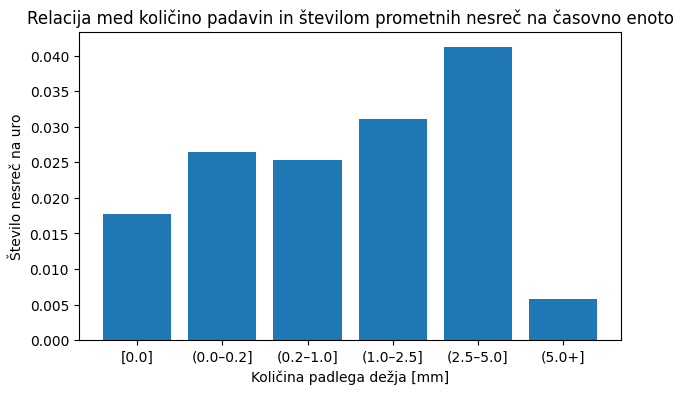

In [10]:
accident_rate = [x / y for x, y in zip(count_accidents, count_hours)]
print(accident_rate)

# Stolpčni diagram
oznake = ["[0.0]", "(0.0–0.2]", "(0.2–1.0]", "(1.0–2.5]", "(2.5–5.0]", "(5.0+]"]
plt.figure(figsize=(7, 4))
plt.bar(oznake, accident_rate)

plt.xlabel('Količina padlega dežja [mm]')
plt.ylabel('Število nesreč na uro')
plt.title('Relacija med količino padavin in številom prometnih nesreč na časovno enoto')

plt.show()

*Opazka: Vidimo, da je število nesreč pri zelo velikih količinah dežja nižje. Razlog za to je najbrž, da ni dovolj podatkov.*

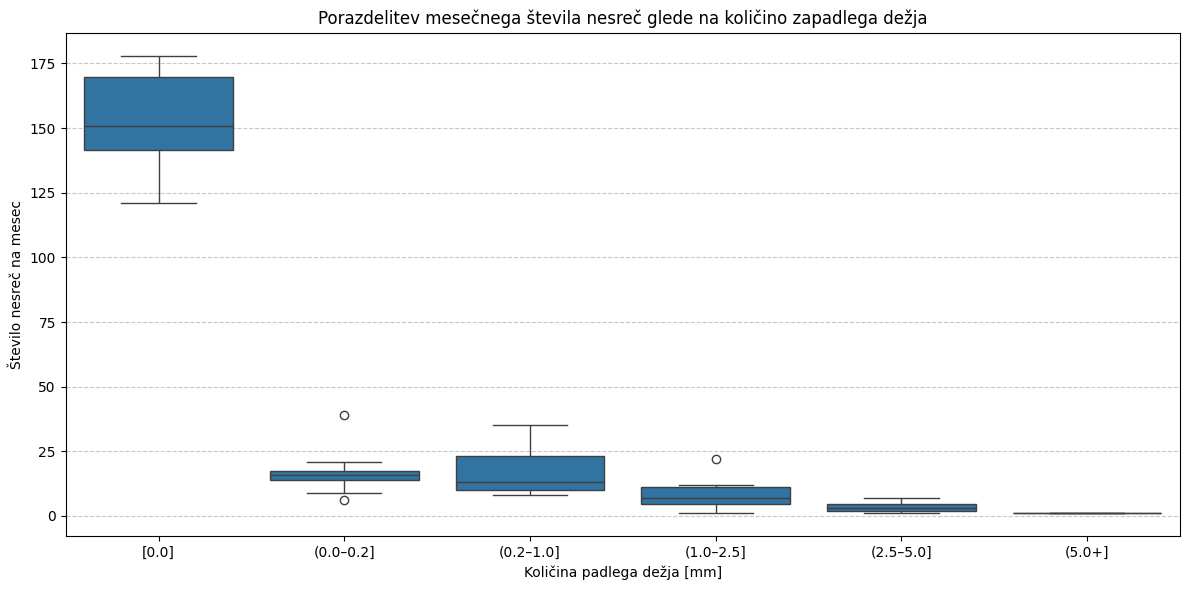

In [65]:
# BOXPLOT
# Najprej grupiram in preštejem nesreče
grouped = lj_accidents.groupby(['Mesec_SLO', 'Dez_interval']).size()
      
# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='Dez_interval', y='accident_count', order=oznake)
plt.title('Porazdelitev mesečnega števila nesreč glede na količino zapadlega dežja')
plt.xlabel('Količina padlega dežja [mm]')
plt.ylabel('Število nesreč na mesec')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Resnost posledic prometnih nesreč glede na količino padlega dežja**

Tri kategorije nesreč:
- **Nesreče brez poškodovancev**: udeleženci niso bili poškodovani in nihče ni umrl
- **Nesreče s poškodbami**: nekateri udeleženci so bili poškodovani, vendar nihče ni umrl
- **Nesreče s smrtnim izidom**: vsaj eden od udeležencev je umrl (v nesreči so bili lahko tudi drugi, ki so bili poškodovani, vendar take nesreče ne štejem v kategorijo "Nesreče s poškodbami")

In [11]:
count_no_injury = [0] * len(intervali)
count_injury = [0] * len(intervali)
count_death = [0] * len(intervali)

for i, (a,b) in enumerate(intervali):
    if i == 0:
        rain_mask = (lj_accidents['SkupenDez'] == 0.0)

        count_no_injury[i] = sum( rain_mask & (accidents_weather['LjudjePoskodovani'] == 0) & (accidents_weather['LjudjeMrtvi'] == 0) )
        count_injury[i] = sum( rain_mask & (accidents_weather['LjudjePoskodovani'] != 0) & (accidents_weather['LjudjeMrtvi'] == 0) )
        count_death[i] = sum( rain_mask & (accidents_weather['LjudjeMrtvi'] != 0) )

    else:
        rain_mask = (lj_accidents['SkupenDez'] > a) & (lj_accidents['SkupenDez'] <= b)

        count_no_injury[i] = sum( rain_mask & (accidents_weather['LjudjePoskodovani'] == 0) & (accidents_weather['LjudjeMrtvi'] == 0) )
        count_injury[i] = sum( rain_mask & (accidents_weather['LjudjePoskodovani'] != 0) & (accidents_weather['LjudjeMrtvi'] == 0) )
        count_death[i] = sum( rain_mask & (accidents_weather['LjudjeMrtvi'] != 0) )


# Število nesreč na uro pri različnih količinah padavin
no_injury_rate = [x / y for x,y in zip(count_no_injury, count_hours)]
injury_rate = [x / y for x,y in zip(count_injury, count_hours)]
death_rate = [x / y for x,y in zip(count_death, count_hours)]

print(type(count_death))
print(count_death)

<class 'list'>
[89, 8, 10, 5, 0, 0]


## Nesreče brez poškodovancev

Število nesreč brez poškodb:  [512, 68, 84, 37, 15, 1]
Verjetnost prometne nesreče brez poškodb:  [0.004973143084708556, 0.008984013740256308, 0.01058601134215501, 0.01170886075949367, 0.016268980477223426, 0.005780346820809248]


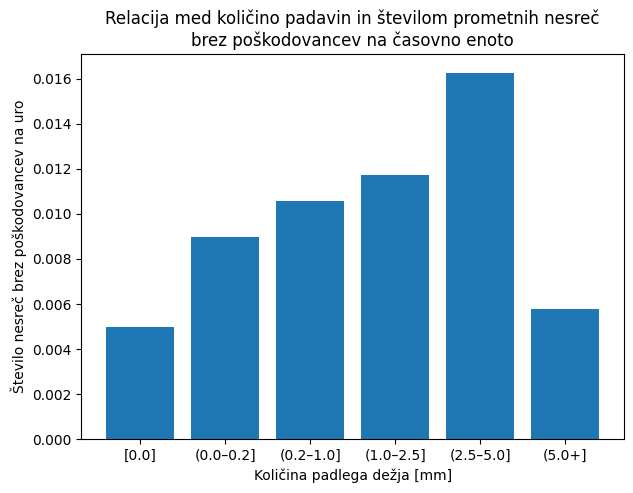

In [12]:
print("Število nesreč brez poškodb: ", count_no_injury)
print("Verjetnost prometne nesreče brez poškodb: ", no_injury_rate)

# Stolpčni diagram
oznake = ["[0.0]", "(0.0–0.2]", "(0.2–1.0]", "(1.0–2.5]", "(2.5–5.0]", "(5.0+]"]
plt.figure(figsize=(7, 5))
plt.bar(oznake, no_injury_rate)

plt.xlabel('Količina padlega dežja [mm]')
plt.ylabel('Število nesreč brez poškodovancev na uro')
plt.title('Relacija med količino padavin in številom prometnih nesreč\nbrez poškodovancev na časovno enoto')

plt.show()

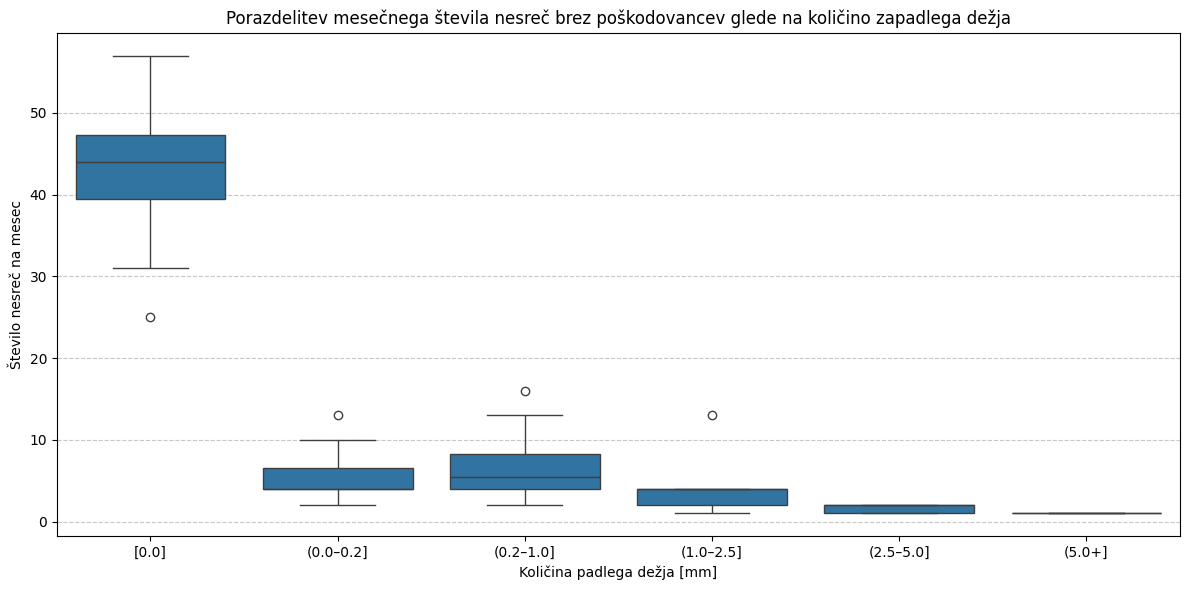

In [66]:
# BOXPLOT
mask_no_injury = (lj_accidents['Severity'] == 'no_injury')
df_no_injury = lj_accidents[mask_no_injury]

# Najprej grupiram in preštejem nesreče
grouped = df_no_injury.groupby(['Mesec_SLO', 'Dez_interval']).size()

# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='Dez_interval', y='accident_count', order=oznake)
plt.title('Porazdelitev mesečnega števila nesreč brez poškodovancev glede na količino zapadlega dežja')
plt.xlabel('Količina padlega dežja [mm]')
plt.ylabel('Število nesreč na mesec')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Nesreče s poškodbami

Število nesreč s poškodbami:  [1222, 124, 107, 56, 23, 0]
Verjetnost prometne nesreče s poškodbami:  [0.01186949384670675, 0.01638261329105562, 0.013484562066792691, 0.017721518987341773, 0.024945770065075923, 0.0]


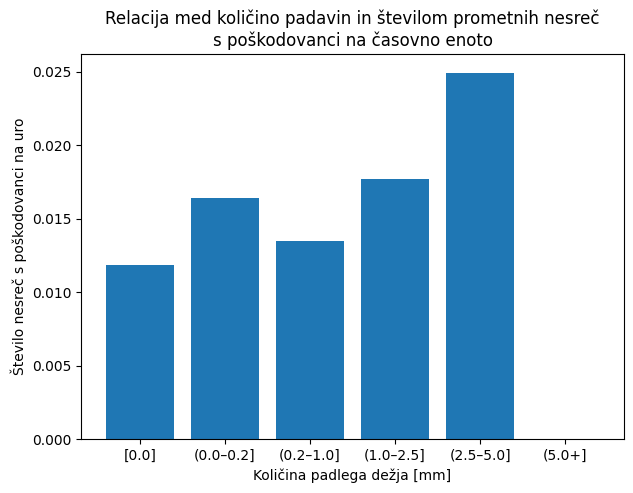

In [13]:
print("Število nesreč s poškodbami: ", count_injury)
print("Verjetnost prometne nesreče s poškodbami: ", injury_rate)

# Stolpčni diagram
oznake = ["[0.0]", "(0.0–0.2]", "(0.2–1.0]", "(1.0–2.5]", "(2.5–5.0]", "(5.0+]"]
plt.figure(figsize=(7, 5))
plt.bar(oznake, injury_rate)

plt.xlabel('Količina padlega dežja [mm]')
plt.ylabel('Število nesreč s poškodovanci na uro')
plt.title('Relacija med količino padavin in številom prometnih nesreč\ns poškodovanci na časovno enoto')

plt.show()

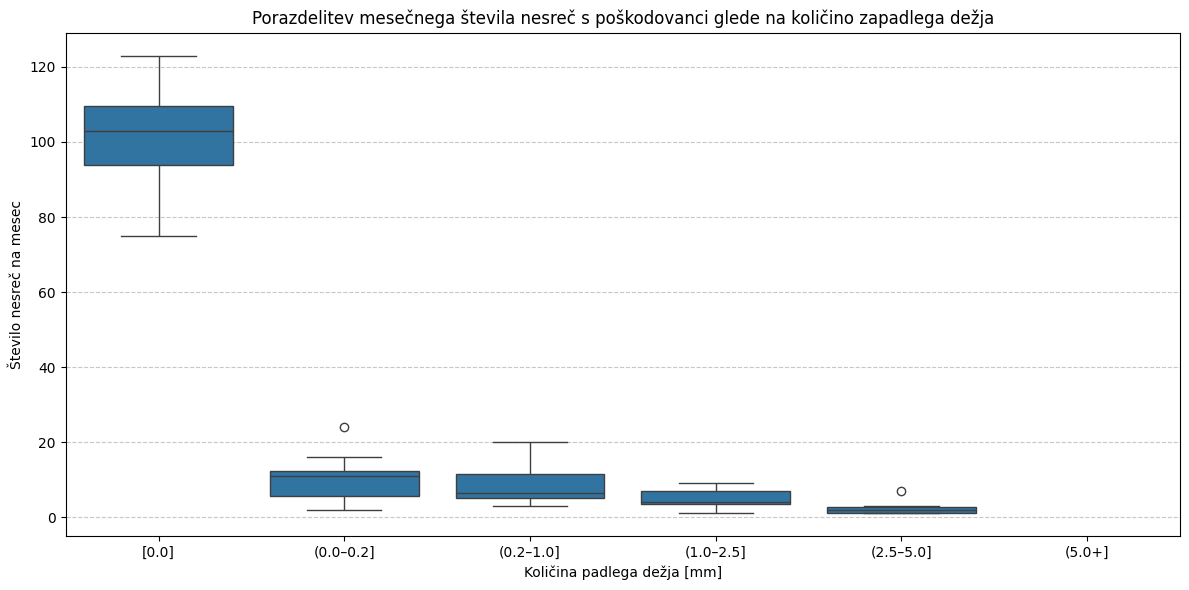

In [67]:
# BOXPLOT
mask_injury = (lj_accidents['Severity'] == 'injury')
df_injury = lj_accidents[mask_injury]

# Najprej grupiram in preštejem nesreče
grouped = df_injury.groupby(['Mesec_SLO', 'Dez_interval']).size()

# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='Dez_interval', y='accident_count', order=oznake)
plt.title('Porazdelitev mesečnega števila nesreč s poškodovanci glede na količino zapadlega dežja')
plt.xlabel('Količina padlega dežja [mm]')
plt.ylabel('Število nesreč na mesec')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Nesreče s smrtnim izidom

Število nesreč s smrtnim izidom:  [89, 8, 10, 5, 0, 0]
Verjetnost prometne nesreče s smrtnim izidom:  [0.0008644721377716045, 0.0010569427929713305, 0.001260239445494644, 0.0015822784810126582, 0.0, 0.0]


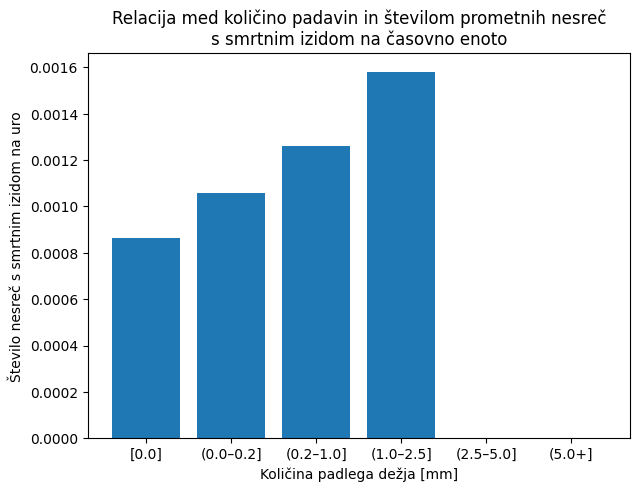

In [14]:
print("Število nesreč s smrtnim izidom: ", count_death)
print("Verjetnost prometne nesreče s smrtnim izidom: ", death_rate)

# Stolpčni diagram
oznake = ["[0.0]", "(0.0–0.2]", "(0.2–1.0]", "(1.0–2.5]", "(2.5–5.0]", "(5.0+]"]
plt.figure(figsize=(7, 5))
plt.bar(oznake, death_rate)

plt.xlabel('Količina padlega dežja [mm]')
plt.ylabel('Število nesreč s smrtnim izidom na uro')
plt.title('Relacija med količino padavin in številom prometnih nesreč\ns smrtnim izidom na časovno enoto')

plt.show()

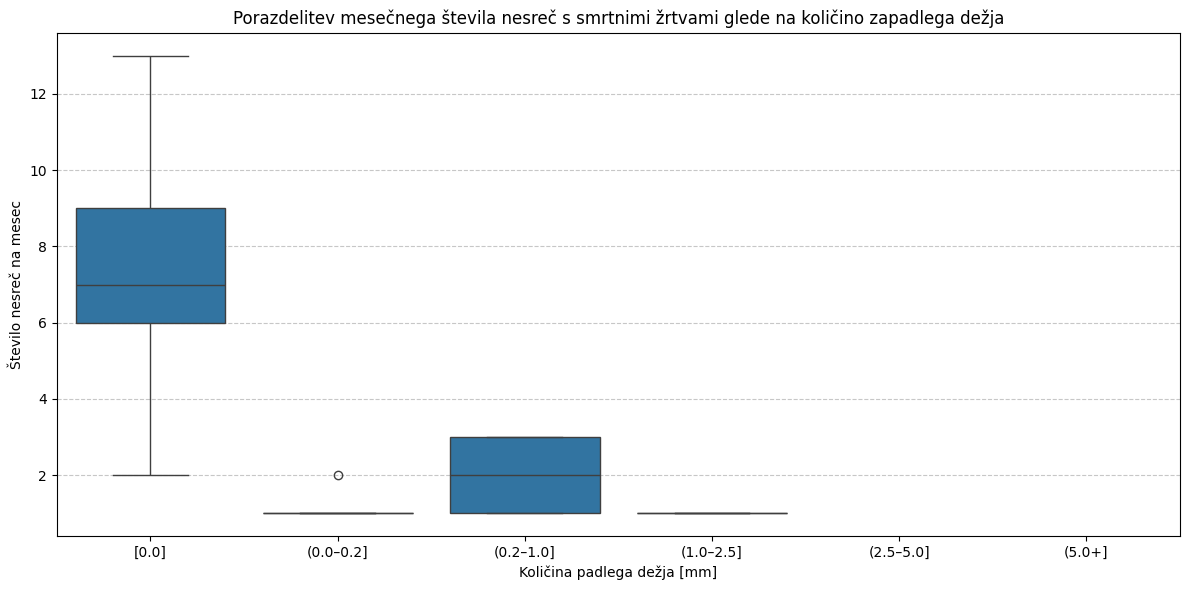

In [68]:
# BOXPLOT
mask_death = (lj_accidents['Severity'] == 'death')
df_death = lj_accidents[mask_death]

# Najprej grupiram in preštejem nesreče
grouped = df_death.groupby(['Mesec_SLO', 'Dez_interval']).size()

# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='Dez_interval', y='accident_count', order=oznake)
plt.title('Porazdelitev mesečnega števila nesreč s smrtnimi žrtvami glede na količino zapadlega dežja')
plt.xlabel('Količina padlega dežja [mm]')
plt.ylabel('Število nesreč na mesec')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Združen pogled

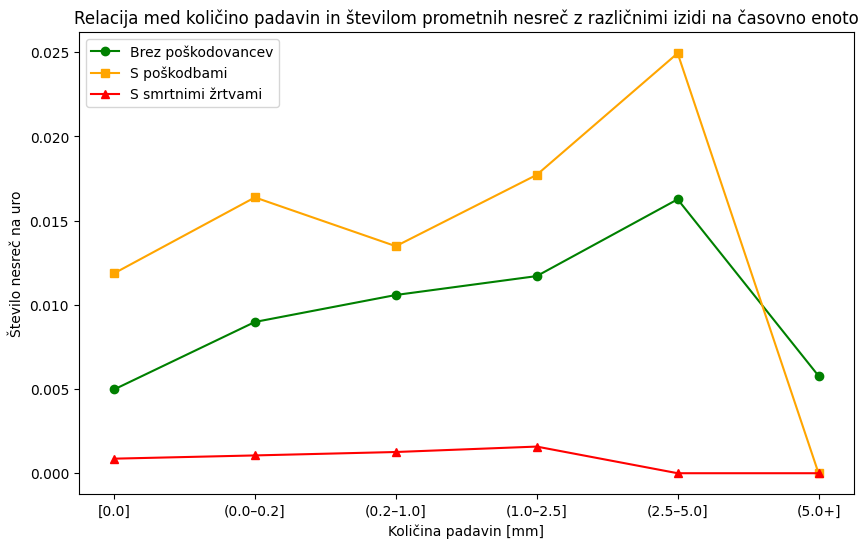

In [15]:
oznake = ["[0.0]", "(0.0–0.2]", "(0.2–1.0]", "(1.0–2.5]", "(2.5–5.0]", "(5.0+]"]
plt.figure(figsize=(10, 6))

plt.plot(oznake, no_injury_rate, marker='o', linestyle='-', label='Brez poškodovancev', color='green')
plt.plot(oznake, injury_rate, marker='s', linestyle='-', label='S poškodbami', color='orange')
plt.plot(oznake, death_rate, marker='^', linestyle='-', label='S smrtnimi žrtvami', color='red')

plt.xlabel('Količina padavin [mm]')
plt.ylabel('Število nesreč na uro')
plt.title('Relacija med količino padavin in številom prometnih nesreč z različnimi izidi na časovno enoto')
plt.legend()

plt.show()

# **Kako količina dežja vpliva na resnost prometnih nesreč**

Kako se spreminja delež treh kategorij nesreč glede na količino zapadlega dežja.

Poglejmo, kako se resnost nesreč spreminja z dežjem - kolikšen delež nesreč je bil "resnih" v posameznem deževnem intervalu – ne le, koliko nesreč se je zgodilo.

Dež lahko spremeni vrsto nesreč, ki se zgodijo.

Od vseh nesreč, ki so se zgodile v tem deževnem intervalu, kolikšen delež nesreč je povzročil poškodbe ali smrt?


In [16]:
no_injury_share = [0] * len(intervali)
injury_share = [0] * len(intervali)
death_share = [0] * len(intervali)

for i in range(len(intervali)):
    total = count_no_injury[i] + count_injury[i] + count_death[i]

    no_injury_share[i] = count_no_injury[i] / total
    injury_share[i] = count_injury[i] / total
    death_share[i] = count_death[i] / total

print(no_injury_share)
print(injury_share)
print(death_share)

[0.28085573230938016, 0.34, 0.417910447761194, 0.37755102040816324, 0.39473684210526316, 1.0]
[0.6703236423477784, 0.62, 0.5323383084577115, 0.5714285714285714, 0.6052631578947368, 0.0]
[0.04882062534284147, 0.04, 0.04975124378109453, 0.05102040816326531, 0.0, 0.0]


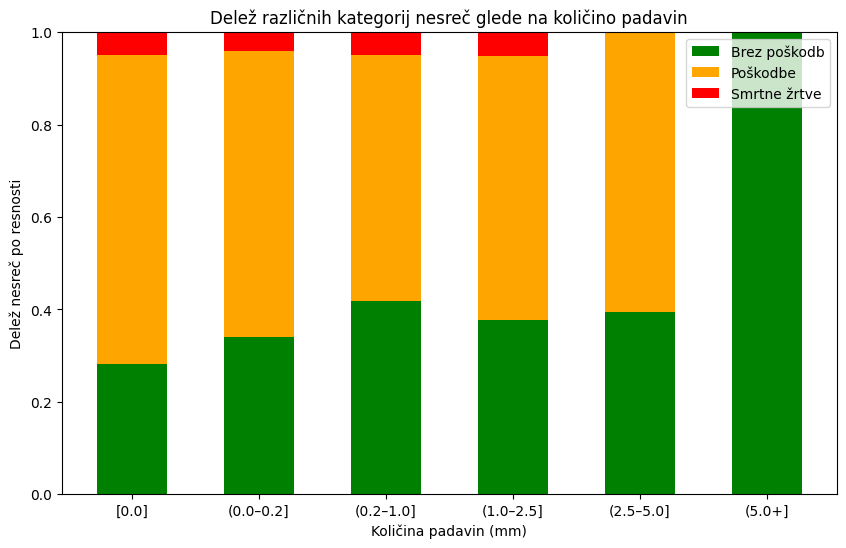

In [17]:
oznake = ["[0.0]", "(0.0–0.2]", "(0.2–1.0]", "(1.0–2.5]", "(2.5–5.0]", "(5.0+]"]
x = range(len(intervali))  # x pozicija za stolpce
width = 0.55  # debelina posameznega stolpca

plt.figure(figsize=(10, 6))

# Stolpci en na drugem, za lažjo predstavitev deležov
plt.bar(x, no_injury_share, width=width, label="Brez poškodb", color='green')
plt.bar(x, injury_share, width=width, bottom=no_injury_share, label="Poškodbe", color='orange')

# Izračun dna za tretjo kategorijo --> bottom_two = no_injury_share + injury_share
bottom_two = [ni + inj for ni, inj in zip(no_injury_share, injury_share)]
plt.bar(x, death_share, width=width, bottom=bottom_two, label="Smrtne žrtve", color='red')

plt.xticks(ticks=x, labels=oznake)  # oznake na x-osi
plt.xlabel("Količina padavin (mm)")
plt.ylabel("Delež nesreč po resnosti")
plt.title("Delež različnih kategorij nesreč glede na količino padavin")
plt.legend()

plt.show()

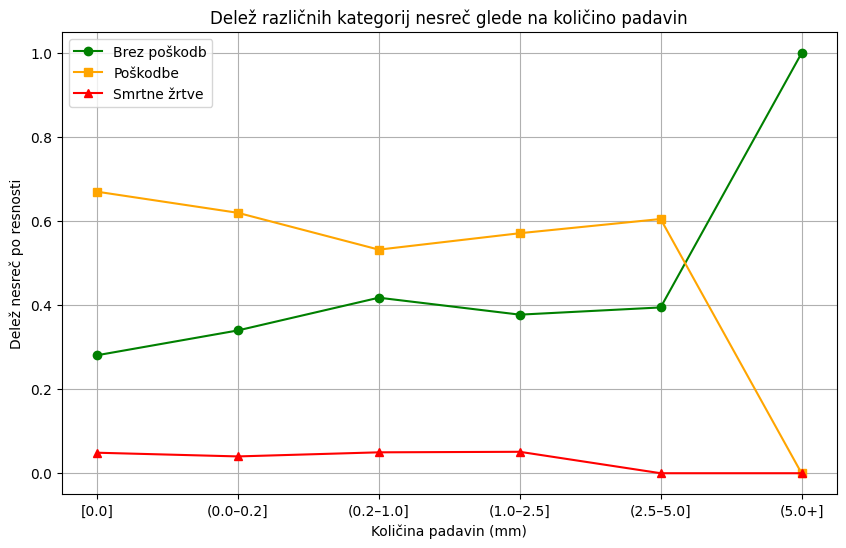

In [18]:
oznake = ["[0.0]", "(0.0–0.2]", "(0.2–1.0]", "(1.0–2.5]", "(2.5–5.0]", "(5.0+]"]
x = range(len(intervali))  # x pozicija za stolpce

plt.figure(figsize=(10, 6))


plt.plot(x, no_injury_share, marker='o', label="Brez poškodb", color='green')
plt.plot(x, injury_share, marker='s', label="Poškodbe", color='orange')
plt.plot(x, death_share, marker='^', label="Smrtne žrtve", color='red')


plt.xticks(ticks=x, labels=oznake)  # oznake na x-osi
plt.xlabel("Količina padavin (mm)")
plt.ylabel("Delež nesreč po resnosti")
plt.title("Delež različnih kategorij nesreč glede na količino padavin")
plt.legend()
plt.grid(True)

plt.show()

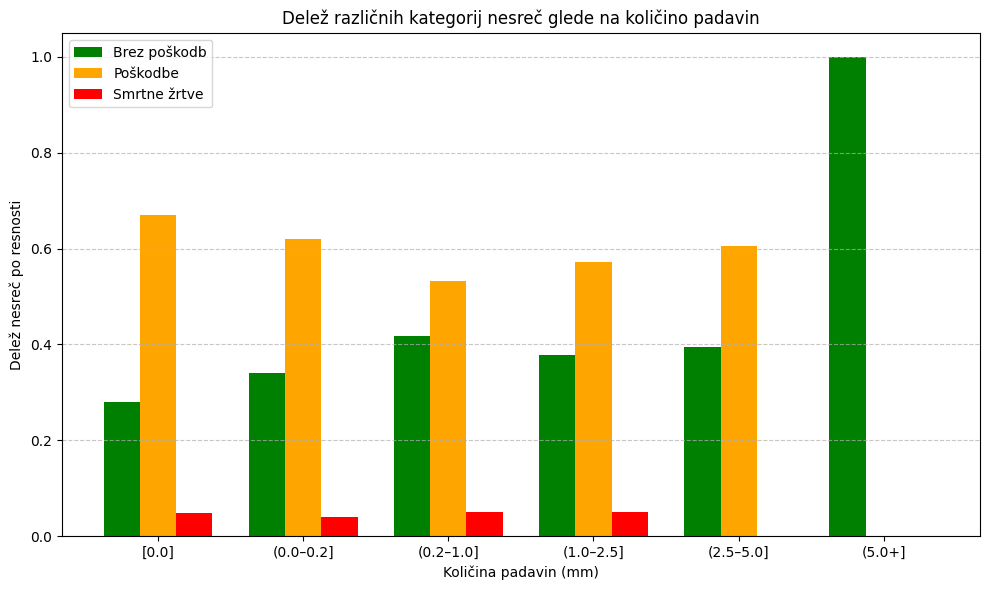

In [19]:
oznake = ["[0.0]", "(0.0–0.2]", "(0.2–1.0]", "(1.0–2.5]", "(2.5–5.0]", "(5.0+]"]
x = np.arange(len(intervali))  # x pozicija za stolpce

width = 0.25  # širina vsakega stolpca

plt.figure(figsize=(10, 6))

# Vsaka kategorija z zamikom po x-osi
plt.bar(x - width, no_injury_share, width, label="Brez poškodb", color='green')
plt.bar(x, injury_share, width, label="Poškodbe", color='orange')
plt.bar(x + width, death_share, width, label="Smrtne žrtve", color='red')


plt.xticks(ticks=x, labels=oznake)
plt.xlabel("Količina padavin (mm)")
plt.ylabel("Delež nesreč po resnosti")
plt.title("Delež različnih kategorij nesreč glede na količino padavin")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Boxplot

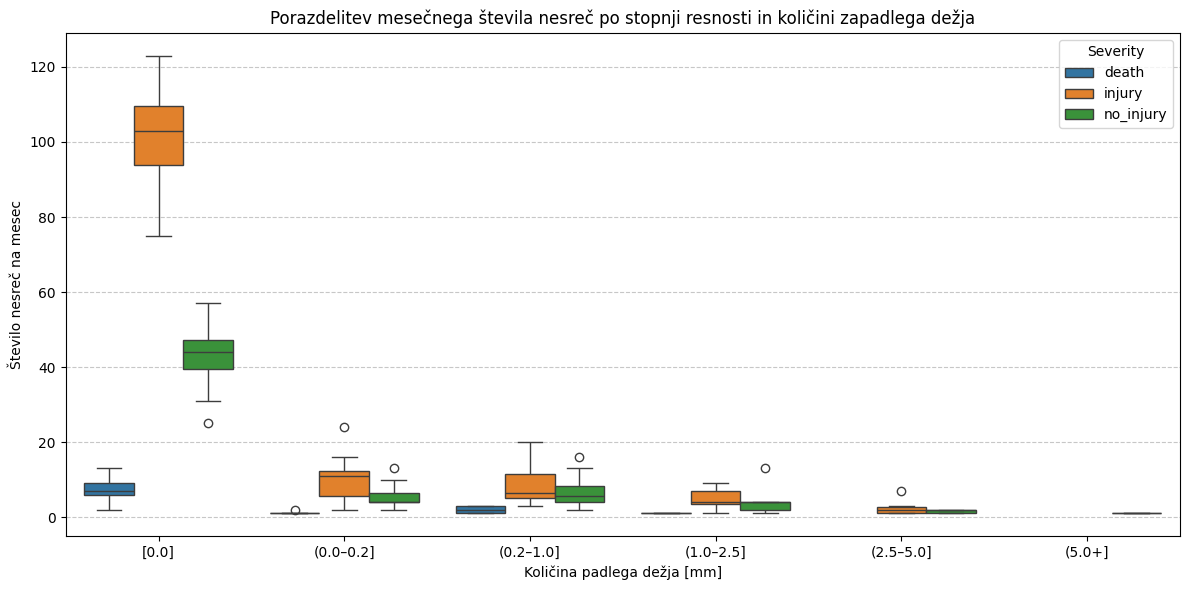

In [69]:
# Najprej grupiram in preštejem nesreče
grouped = lj_accidents.groupby(['Mesec_SLO', 'Dez_interval', 'Severity']).size()
      
# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='Dez_interval', y='accident_count', hue='Severity', order=oznake)
plt.title('Porazdelitev mesečnega števila nesreč po stopnji resnosti in količini zapadlega dežja')
plt.xlabel('Količina padlega dežja [mm]')
plt.ylabel('Število nesreč na mesec')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Heatmap

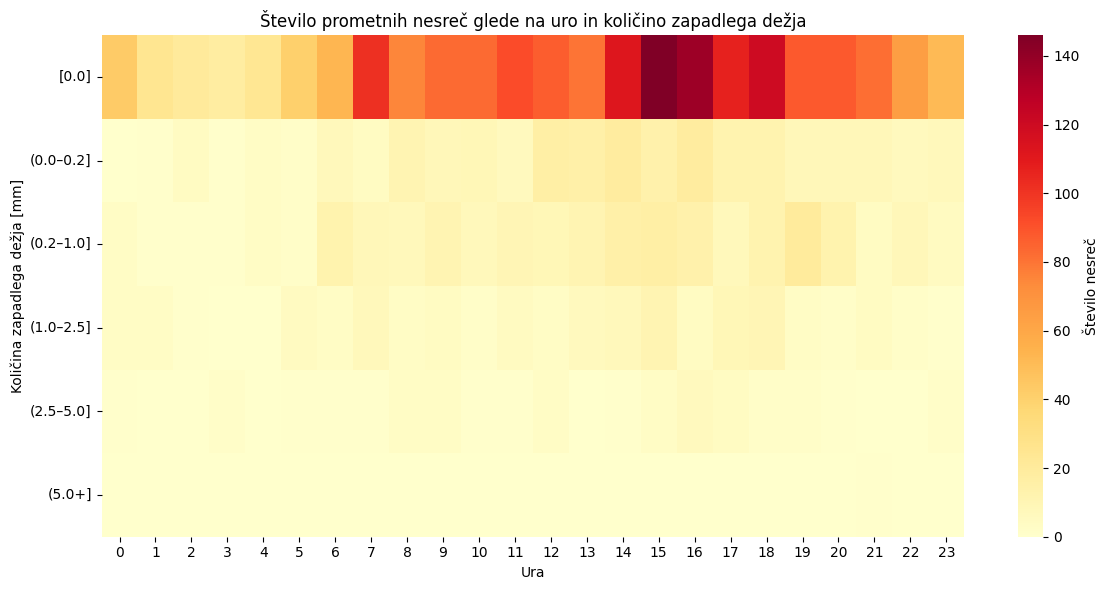

In [ ]:
grouped = lj_accidents.groupby(['Ura', 'Dez_interval']).size()
grouped = grouped.reset_index(name='accident_count')

# Dežne intervale razporedi po vrstnem redu
cat_type_rain = CategoricalDtype(categories=oznake, ordered=True)
grouped['Dez_interval'] = grouped['Dez_interval'].astype(cat_type_rain) 
grouped = grouped.sort_values(['Dez_interval'])

grouped['Ura'] = grouped['Ura'].astype(int)   # Da bodo ure smatrane kot številke in ne stringi. Da se bodo pravilno razporedile po x-osi.

df_heatmap = grouped.pivot(index='Dez_interval', columns='Ura', values='accident_count').fillna(0)
# display(df_heatmap)

# Heatmap
plt.figure(figsize=(12, 6))

sns.heatmap(df_heatmap, 
            annot=False,
            cmap='YlOrRd',
            cbar_kws={'label': 'Število nesreč'})
plt.xlabel('Ura')
plt.ylabel('Količina zapadlega dežja [mm]')
plt.title('Število prometnih nesreč glede na uro in količino zapadlega dežja')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

Še heatmap brez nesreč, ki so zgodile med suhim vremenom.

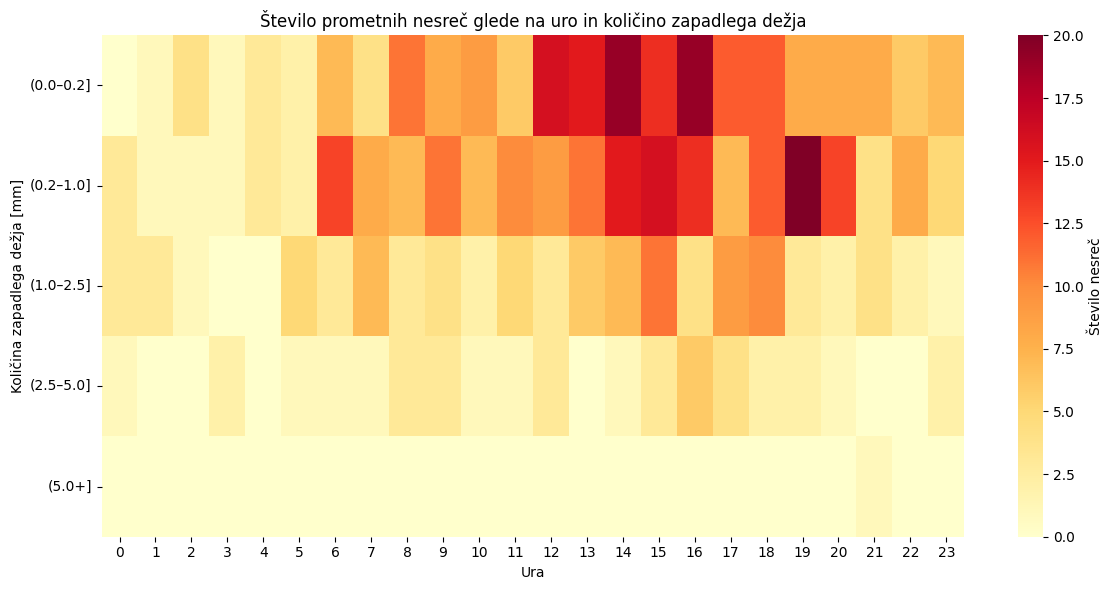

In [ ]:
grouped = lj_accidents.groupby(['Dez_interval', 'Ura']).size()
grouped = grouped.reset_index(name='accident_count')

# Brez kategorije [0.0]
grouped = grouped[grouped['Dez_interval'] != '[0.0]']

# Dežne intervale razporedi po vrstnem redu
oznake_filtered = [label for label in oznake if label != '[0.0]']
cat_type_rain = CategoricalDtype(categories=oznake_filtered, ordered=True)
grouped['Dez_interval'] = grouped['Dez_interval'].astype(cat_type_rain) 
grouped = grouped.sort_values(['Dez_interval'])

grouped['Ura'] = grouped['Ura'].astype(int)   # Da bodo ure smatrane kot številke in ne stringi. Da se bodo pravilno razporedile po x-osi.
# print(grouped)

df_heatmap = grouped.pivot(index='Dez_interval', columns='Ura', values='accident_count').fillna(0)
# display(df_heatmap)

# Heatmap
plt.figure(figsize=(12, 6))

sns.heatmap(df_heatmap, 
            annot=False,
            cmap='YlOrRd',
            cbar_kws={'label': 'Število nesreč'})
plt.xlabel('Ura')
plt.ylabel('Količina zapadlega dežja [mm]')
plt.title('Število prometnih nesreč glede na uro in količino zapadlega dežja')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()